<a href="https://colab.research.google.com/github/MehdiMitiche/kaggle-titanic-challenge-pytorch/blob/main/kaggle_titanic_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#we import dependencies
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from google.colab import drive
import math

In [2]:
#we connect to google drive to import the dataset which is there
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#we read the csv file containing the trainset
titanic = pd.read_csv("/content/gdrive/My Drive/titanic/train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#we read the csv file containing the testset
titanic_test = pd.read_csv("/content/gdrive/My Drive/titanic/test.csv")
titanic_test.head() 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#we get more info about each comuns in trainset
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
#we transform the categorical variables with one hot encoding
categorical_var = ["Sex","Pclass","Embarked"]
for var in categorical_var:
  dummies = pd.get_dummies(titanic[var],prefix=var, drop_first=False)
  titanic = pd.concat([titanic,dummies],axis=1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,1,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1,0,0,1


In [7]:
#we drop the cols that are not really usefull
less_useful_cols = ["PassengerId","Pclass","Name","Sex","Ticket","Embarked","Cabin"]
trainset = titanic.drop(less_useful_cols,axis=1)
trainset.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


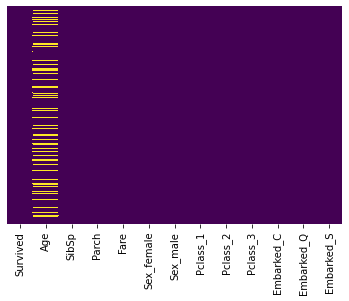

In [8]:
#we get an idea about how many none values we have
sns.heatmap(trainset.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [9]:
#we get the count of missing values in age
trainset["Age"].isnull().sum()

177

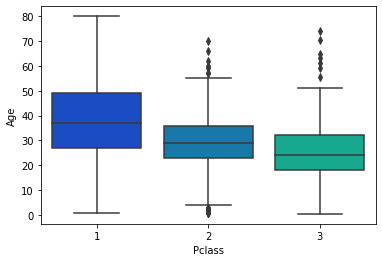

In [10]:
#we try to find the best guess for the missing values in age col, 
#we plot the age values by class
sns.boxplot(x='Pclass',y='Age',data=titanic,palette='winter')

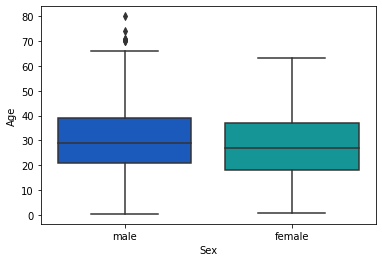

In [11]:
#we plot the age values by sex
sns.boxplot(x="Sex",y="Age",data=titanic,palette='winter')

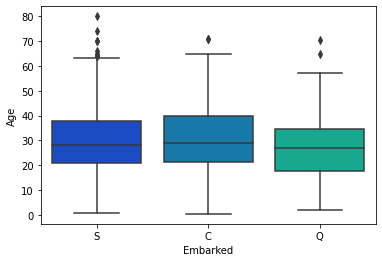

In [12]:
#we plot the age value by where the person embarked
sns.boxplot(x="Embarked",y="Age",data=titanic,palette="winter")

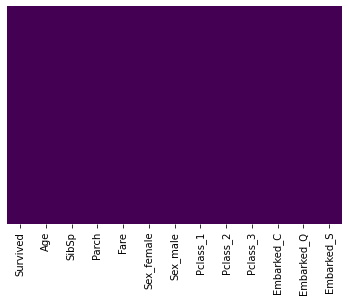

In [13]:
#there is more information when we plotted the age by class, so we will fill the age missing values by the average of each class
mean_age_1 = trainset[trainset["Pclass_1"] == 1]["Age"].mean()
mean_age_2 = trainset[trainset["Pclass_2"] == 1]["Age"].mean()
mean_age_3 = trainset[trainset["Pclass_3"] == 1]["Age"].mean()

def fill_missing_age(x):
  if(math.isnan(x["Age"])):
    if(x["Pclass_1"] ==1):
      return mean_age_1
    if(x["Pclass_2"] ==1):
      return mean_age_2
    if(x["Pclass_3"] ==1):
      return mean_age_2
  else:
    return x["Age"]

trainset["Age"] = trainset.apply(fill_missing_age,axis=1)
sns.heatmap(trainset.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [14]:
trainset.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [15]:
#we normlize some cols
cols_to_normlize = ["Age","Fare"]
def normlize(data,cols):
  for col in cols:
    mean = data[col].mean()
    std = data[col].std()
    data[col] = data.apply(lambda x:(x[col] - mean)/std,axis=1)

normlize(trainset,cols_to_normlize)


In [16]:
trainset.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.612255,1,0,-0.502163,0,1,0,0,1,0,0,1
1,1,0.609823,1,0,0.786404,1,0,1,0,0,1,0,0
2,1,-0.306736,0,0,-0.488580,1,0,0,0,1,0,0,1
3,1,0.380683,1,0,0.420494,1,0,1,0,0,0,0,1
4,0,0.380683,0,0,-0.486064,0,1,0,0,1,0,0,1


In [17]:
#we transform the categorical variables with one hot encoding in the testset
for var in categorical_var:
  dummies = pd.get_dummies(titanic_test[var],prefix=var, drop_first=False)
  titanic_test = pd.concat([titanic_test,dummies],axis=1)
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,1,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,0,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0,0,0,1,0,0,1


In [18]:
#we drop the cols that are not really usefull in the testset
testset = titanic_test.drop(less_useful_cols,axis=1)
testset.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,1,0,0,1,0,1,0
1,47.0,1,0,7.0000,1,0,0,0,1,0,0,1
2,62.0,0,0,9.6875,0,1,0,1,0,0,1,0
3,27.0,0,0,8.6625,0,1,0,0,1,0,0,1
4,22.0,1,1,12.2875,1,0,0,0,1,0,0,1


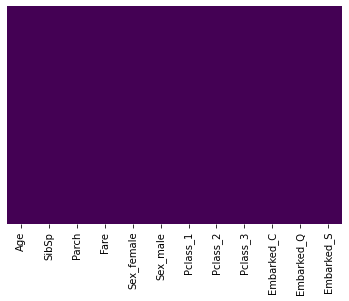

In [19]:
#we fill the age missing values in the test set

testset["Age"] = testset.apply(fill_missing_age,axis=1)
sns.heatmap(testset.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [20]:
testset.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,1,0,0,1,0,1,0
1,47.0,1,0,7.0000,1,0,0,0,1,0,0,1
2,62.0,0,0,9.6875,0,1,0,1,0,0,1,0
3,27.0,0,0,8.6625,0,1,0,0,1,0,0,1
4,22.0,1,1,12.2875,1,0,0,0,1,0,0,1


In [21]:
normlize(testset,cols_to_normlize)
testset.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0.325373,0,0,-0.497213,0,1,0,0,1,0,1,0
1,1.310455,1,0,-0.512045,1,0,0,0,1,0,0,1
2,2.492554,0,0,-0.463974,0,1,0,1,0,0,1,0
3,-0.265676,0,0,-0.482308,0,1,0,0,1,0,0,1
4,-0.659709,1,1,-0.417469,1,0,0,0,1,0,0,1


In [22]:
trainset.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.612255,1,0,-0.502163,0,1,0,0,1,0,0,1
1,1,0.609823,1,0,0.786404,1,0,1,0,0,1,0,0
2,1,-0.306736,0,0,-0.488580,1,0,0,0,1,0,0,1
3,1,0.380683,1,0,0.420494,1,0,1,0,0,0,0,1
4,0,0.380683,0,0,-0.486064,0,1,0,0,1,0,0,1


In [23]:
class set_up_data(data.Dataset):
  def __init__(self,filename):
    data_matrix = filename.values
    data_matrix = torch.from_numpy(data_matrix)
    self.data = data_matrix[:,1:13]
    self.data = self.data.float()
    self.target = data_matrix[:,0]

    self.n_samples = self.data.shape[0]

  def __len__(self):
    return self.n_samples
  
  def __getitem__(self,index):
    return self.data[index], self.target[index]

In [24]:
train_data = set_up_data(trainset)
train_loader = data.DataLoader(train_data,batch_size=200)

test_data = set_up_data(testset)
test_loader = data.DataLoader(test_data,batch_size=200)

In [25]:
from torch import nn
from torch.functional import F

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(12,64)
    self.fc2 = nn.Linear(64,128)
    self.fc3 = nn.Linear(128,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64,2)
  
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    x = self.fc5(x)
    return F.log_softmax(x,dim=1)

nn_model = Network()
nn_model


Network(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [26]:
nn_model(torch.randn([1,12]))

tensor([[-0.6210, -0.7709]], grad_fn=<LogSoftmaxBackward>)

In [27]:
import torch.optim as optim 

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(),lr=0.001)

In [ ]:
epochs = 250
for epoch in range(epochs):
  train_loss= 0
  for data,target in train_loader:
    output = nn_model(data)


    loss = loss_function(output,target.type(torch.LongTensor))
    train_loss += loss.item()*data.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss = train_loss / len(train_loader.dataset)
  print(f"In epoch loss : {train_loss}")

In [29]:
total = 0
true_answers = 0
with torch.no_grad():
  for data,target in train_loader:
    output = nn_model(data)
    for index, row in enumerate(output):
      if( torch.argmax(row).item() == target[index].item() ):
        true_answers +=1
      total +=1
  
  print(true_answers / total * 100)

91.58249158249158


In [50]:
predictions = torch.from_numpy(testset.values)


In [54]:
result = {"passengerId" : [],"Survived":[]}
with torch.no_grad():
  for index,item in enumerate(predictions):
    result["Survived"].append(torch.argmax(nn_model(predictions.float())[index]).item())

In [ ]:
result

In [57]:
titanic_test = pd.read_csv("/content/gdrive/My Drive/titanic/test.csv")
titanic_test["PassengerId"].values

for val in titanic_test["PassengerId"].values:
  result["passengerId"].append(val)

In [59]:
result = pd.DataFrame(result)
result

,passengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
result.set_index("passengerId").to_csv()